### (Optional) Install Neural A* on Colab

We highly recommend the use of GPUs for faster training/planning.

In [ ]:
!git clone https://github.com/omron-sinicx/neural-astar

In [ ]:
%cd neural-astar
!pip install .

## Run Neural A*

In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from neural_astar.planner import NeuralAstar, VanillaAstar
from neural_astar.utils.data import create_dataloader
from neural_astar.utils.training import set_global_seeds, calc_metrics_from_multiple_results, visualize_results

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/yonetani/programs/omron-sinicx/neural-astar/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
neural_astar = NeuralAstar(encoder_arch='CNN').to(device)
neural_astar.load_state_dict(torch.load("data/cnn_mazes.pt", map_location=torch.device(device)))

vanilla_astar = VanillaAstar().to(device)

In [3]:
# average performances over 5 starts

set_global_seeds(1234)
dataloader = create_dataloader("data/mazes_032_moore_c8.npz", "test", 100, shuffle=False, num_starts=5)
va_outputs_list, na_outputs_list = [], []
with torch.no_grad():
    for map_designs, start_maps, goal_maps, opt_trajs in dataloader:
        for i in tqdm(range(start_maps.shape[1])):
            vanilla_astar.eval()
            va_outputs_list.append(vanilla_astar(map_designs.to(device), start_maps[:, i:i+1].to(device), goal_maps.to(device)))
            neural_astar.eval()
            na_outputs_list.append(neural_astar(map_designs.to(device), start_maps[:, i:i+1].to(device), goal_maps.to(device)))
            
calc_metrics_from_multiple_results(na_outputs_list, va_outputs_list)

Number of Test Samples: 100
	Size: 32x32


  0%|                                                                                                                                         | 0/5 [00:00<?, ?it/s]/home/yonetani/programs/omron-sinicx/neural-astar/.venv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


optimality: 0.782, efficiency: 0.431, h_mean: 0.501

Number of Test Samples: 100
	Size: 32x32


(-0.5, 171.5, 35.5, -0.5)

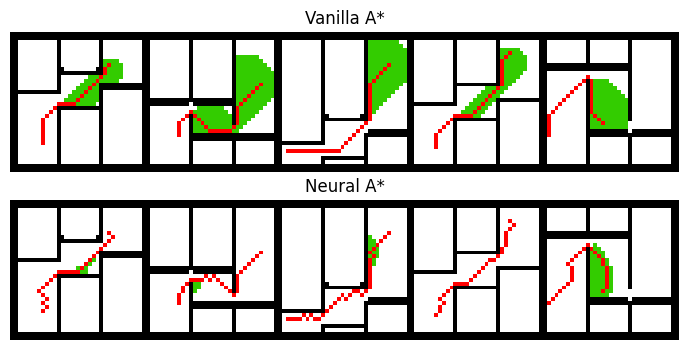

In [4]:
# Visualization

dataloader = create_dataloader("data/mazes_032_moore_c8.npz", "test", 5, shuffle=False, num_starts=1)
map_designs, start_maps, goal_maps, opt_trajs = next(iter(dataloader))
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
va_outputs = vanilla_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))

plt.figure(figsize=[12, 4])
plt.subplot(2, 1, 1)
plt.imshow(visualize_results(map_designs, va_outputs))
plt.title("Vanilla A*")
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(visualize_results(map_designs, na_outputs))
plt.title("Neural A*")
plt.axis("off")


In [5]:
# Create gif animation

import moviepy.editor as mpy
from PIL import Image

instance_id = 1

na_outputs = neural_astar(map_designs[instance_id:instance_id + 1].to(device), 
                          start_maps[instance_id:instance_id + 1].to(device), 
                          goal_maps[instance_id:instance_id + 1].to(device), store_intermediate_results=True)
frames = [visualize_results(map_designs[instance_id:instance_id + 1], intermediate_results, scale=4) for intermediate_results in na_outputs.intermediate_results]
clip = mpy.ImageSequenceClip(frames + [frames[-1]] * 15, fps=30)
clip.write_gif("neural_astar.gif")


va_outputs = vanilla_astar(map_designs[instance_id:instance_id + 1].to(device), 
                          start_maps[instance_id:instance_id + 1].to(device), 
                          goal_maps[instance_id:instance_id + 1].to(device), store_intermediate_results=True)
frames = [visualize_results(map_designs[instance_id:instance_id + 1], intermediate_results, scale=4) for intermediate_results in va_outputs.intermediate_results]
clip = mpy.ImageSequenceClip(frames + [frames[-1]] * 15, fps=30)
clip.write_gif("astar.gif")

MoviePy - Building file neural_astar.gif with imageio.


t:  38%|███▊      | 89/236 [00:00<00:00, 887.18it/s, now=None]

MoviePy - Building file astar.gif with imageio.


## Train Neural A*

In [6]:
# CNN encoder
!python ../scripts/train.py

Number of Train Samples: 800
	Size: 32x32
Number of Validation Samples: 100
	Size: 32x32
Number of Test Samples: 100
	Size: 32x32
validation: 100%|█████████████| 1/1 [00:01<00:00,  1.16s/it]
[epoch:000] train_loss:7.75e-02, val_loss:9.01e-02,  optimality: 0.560, efficiency: 0.377, h_mean: 0.451
best score updated: -1.000 -> 0.451
validation: 100%|█████████████| 1/1 [00:01<00:00,  1.24s/it]
[epoch:001] train_loss:7.40e-02, val_loss:1.00e-01,  optimality: 0.580, efficiency: 0.293, h_mean: 0.389
validation: 100%|█████████████| 1/1 [00:01<00:00,  1.24s/it]
[epoch:002] train_loss:7.08e-02, val_loss:1.03e-01,  optimality: 0.500, efficiency: 0.320, h_mean: 0.390
validation: 100%|█████████████| 1/1 [00:01<00:00,  1.21s/it]
[epoch:003] train_loss:6.91e-02, val_loss:1.07e-01,  optimality: 0.680, efficiency: 0.286, h_mean: 0.402
validation: 100%|█████████████| 1/1 [00:00<00:00,  1.14it/s]
[epoch:004] train_loss:7.01e-02, val_loss:9.03e-02,  optimality: 0.770, efficiency: 0.395, h_mean: 0.522
best